<a href="https://colab.research.google.com/github/txusser/Master_IA_Sanidad/blob/main/Modulo_2/2_3_4_Proyecto_Regresion_Lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este proyecto nuestro objetivo es construir un modelo de regresión lineal simple basado en sci-kit learn para predecir costes médicos a partir del conjunto de datos que puedes encontrar [en este enlace](https:// [texto del enlace](https://))

In [ ]:
# En primer lugar importamos las librerías de trabajo básicas en cualquier 
# proyecto de aprendizaje automático
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Y cargamos los datos contenidos en nuestro dataset 
df = pd.read_csv("insurance.csv")
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


## Exploración de datos
Como hemos visto en el Tema 2.3.3 uno de los primeros pasos que debemos realizar es exploarar los datos y XXX 


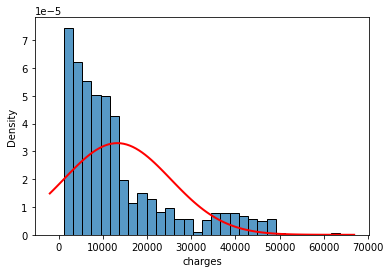

In [ ]:
# Observamos cómo se distribuye la variable objetivo "charges" que
# recoge los cargos realizados al seguro
sns.histplot(df['charges'], stat="density")
# Ajustamos los datos a la dristribución normal
from scipy.stats import norm
mu, std = norm.fit(df['charges'])
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color='red')
plt.show()

De la figura anterior podemos concluir que la variable objetivo "charges" no sigue una distribución normal, sino más bien una distribución mixta, lo que podría ser un problema para obtener un rendimiento óptimo para nuestro modelo lineal

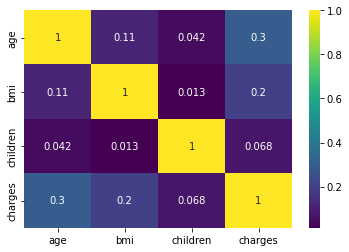

In [ ]:
# Revisamos la matriz de correlación para ver posibles dependencias
sns.heatmap(df.corr(),annot=True, cmap='viridis')

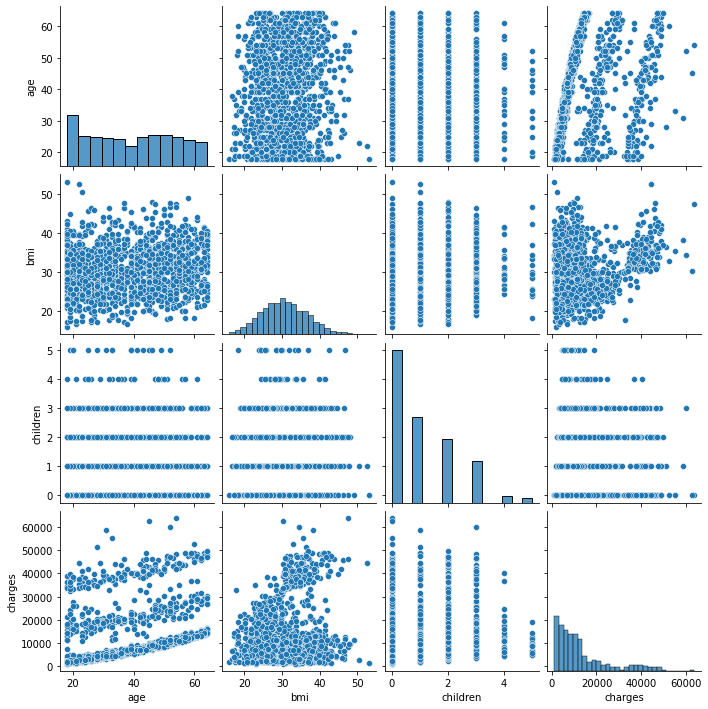

In [ ]:
# Creamos un pair plot para visualizar las morfología de las correlaciones
sns.pairplot(df)

El siguiente paso consiste en codificar las variables categóricas 

In [ ]:
vars = ['sex', 'smoker', 'region']
dummies = [pd.get_dummies(df[var]) for var in vars]
df_d = pd.concat(dummies, axis=1)
df_d.rename(columns={'no': 'non-smoker', 'yes': 'nicotian'}, inplace=True)
df = df.drop(['sex','smoker','region'], axis=1)
df_c = pd.concat([df, df_d], axis=1)
print(df_c.head())

   age     bmi  children  ...  northwest  southeast  southwest
0   19  27.900         0  ...          0          0          1
1   18  33.770         1  ...          0          1          0
2   28  33.000         3  ...          0          1          0
3   33  22.705         0  ...          1          0          0
4   32  28.880         0  ...          1          0          0

[5 rows x 12 columns]
Index(['age', 'bmi', 'children', 'charges', 'female', 'male', 'non-smoker',
       'nicotian', 'northeast', 'northwest', 'southeast', 'southwest'],
      dtype='object')


           age       bmi  children  ...  northwest  southeast  southwest
0    -1.438764 -0.453320 -0.908614  ...  -0.566418  -0.611324   1.765481
1    -1.509965  0.509621 -0.078767  ...  -0.566418   1.635795  -0.566418
2    -0.797954  0.383307  1.580926  ...  -0.566418   1.635795  -0.566418
3    -0.441948 -1.305531 -0.908614  ...   1.765481  -0.611324  -0.566418
4    -0.513149 -0.292556 -0.908614  ...   1.765481  -0.611324  -0.566418
...        ...       ...       ...  ...        ...        ...        ...
1333  0.768473  0.050297  1.580926  ...   1.765481  -0.611324  -0.566418
1334 -1.509965  0.206139 -0.908614  ...  -0.566418  -0.611324  -0.566418
1335 -1.509965  1.014878 -0.908614  ...  -0.566418   1.635795  -0.566418
1336 -1.296362 -0.797813 -0.908614  ...  -0.566418  -0.611324   1.765481
1337  1.551686 -0.261388 -0.908614  ...   1.765481  -0.611324  -0.566418

[1338 rows x 12 columns]


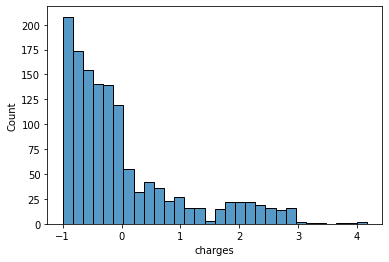

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df_c)
df_s = pd.DataFrame(scaler.fit_transform(df_c), columns=df_c.columns)
print(df_s)
sns.histplot(df_s["charges"])

## Extracción de características

Text(0, 0.5, 'Porcentaje de varianza explicado')

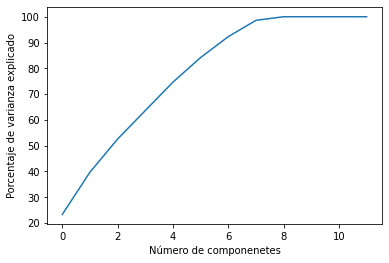

In [ ]:
from sklearn.decomposition import PCA
features = df_s.columns
X = df_s[features]

# PAnalizamos el conjunto completo de variables
pca = PCA(n_components=len(features), random_state=2020)
pca.fit(X)
X_pca = pca.transform(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Número de componenetes")
plt.ylabel("Porcentaje de varianza explicado")

In [ ]:
# Nos quedamos con las 6 variables que explican más del 90% de la varianza
pca_s = PCA(n_components=6, random_state=2020)
pca_s.fit(X)
X_pca_s = pca_s.transform(X)
# X = pca_s.inverse_transform(X_pca_s)
cols = ['PCA' + str(i) for i in range(6)]
df_pca = pd.DataFrame(X_pca_s, columns=cols)
print(df_pca)
print(pd.DataFrame(X))

print("Components:", pd.DataFrame(pca_s.components_, columns=features[0:6], index=cols))



          PCA0      PCA1      PCA2      PCA3      PCA4      PCA5
0     1.794247  1.834668 -0.797065  1.761831 -0.520355 -2.435473
1    -0.622380 -1.748394  1.626639 -0.870391  0.064339 -1.527498
2    -0.414757 -1.690923  1.615243 -0.585496  0.216697 -0.392165
3    -0.195383 -1.336715 -1.440494 -0.418641  1.708185 -0.347876
4    -0.904619 -1.576005 -0.928444 -0.467650  1.681639 -0.477592
...        ...       ...       ...       ...       ...       ...
1333 -0.410680 -1.469268 -0.644184  0.008130  1.909517  1.570023
1334 -1.505168  1.096178 -0.701978 -1.298499 -1.526170 -1.011097
1335 -1.213596  0.991307  2.075771 -0.955261 -0.022759 -1.765757
1336 -1.682817  1.076329 -0.381511  1.619760 -0.594675 -1.842200
1337  2.555342  2.187712 -1.094759 -0.066644  1.767942  0.687237

[1338 rows x 6 columns]
             0         1         2         3         4         5
0     1.794247  1.834668 -0.797065  1.761831 -0.520355 -2.435473
1    -0.622380 -1.748394  1.626639 -0.870391  0.064339 -1.527498


## Ajuste del modelo lineal
Completado el proceso de preparación de datos realizaremos el ajuste del modelo

Index(['PCA0', 'PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'], dtype='object')


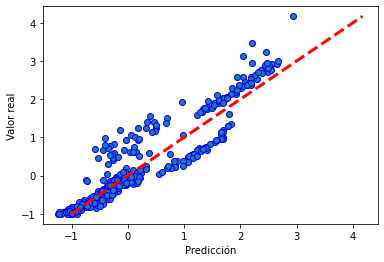

In [ ]:
from sklearn.model_selection import train_test_split
pca_features = df_pca.columns
print(pca_features)
X = df_pca[pca_features]
y = df_s['charges']

# Usamos la funcion propia de sklearn para dividir los datos para
# entrenamiento y prueba  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train ,y_train)

predictions = lm.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(predictions, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicción')
ax.set_ylabel('Valor real')
plt.show()

In [ ]:
from sklearn import metrics
print("MAE: {:.4f}".format(metrics.mean_absolute_error(y_test, predictions)))
print("MSE: {:.4f}".format(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.2353
MSE: 0.1210
